In [98]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

NMSE = 'neg_mean_squared_error'

In [89]:
df = pd.read_csv('communities.csv')
n_row, n_col = df.shape
print('(1) Data Shape: {:d} samples & {:d} features.'.format(n_row, n_col))

miss_stat = df.isnull().sum()  # Series
print('(2) Missing values in each column:\n', 
      miss_stat.value_counts().to_frame(name='freq'))

# columns with multiple missing value (almost over 2/3 NaN, indeed) shall not be used
predictors = [col for col, f in miss_stat.iteritems() if f <= 1]

# delete special columns (response, fold, county & state names, etc.)
response_name = 'ViolentCrimesPerPop'
predictors.remove('communityname')
predictors.remove('fold')
predictors.remove(response_name)

# filter out the row with one missing value
missed_col = miss_stat[miss_stat == 1].index
df = df.loc[~np.isnan(df[missed_col].values.transpose()[0]), :]

# split X & y, train & test sets
row_sel = df['fold'] == 1
X_test, y_test = df.loc[row_sel, predictors], df.loc[row_sel, response_name].values
row_sel = df['fold'] != 1
X_train, y_train = df.loc[row_sel, predictors], df.loc[row_sel, response_name].values

n_row, n_col = X_train.shape
print('(3) X_train shape after transformation: {:d} samples & {:d} features.'
      .format(n_row, n_col))
predictors = np.array(predictors)

(1) Data Shape: 1994 samples & 128 features.
(2) Missing values in each column:
       freq
0      103
1675    22
1177     1
1174     1
1        1
(3) X_train shape after transformation: 1794 samples & 101 features.


In [90]:
# Part-II

model_lr = LinearRegression(normalize=True)
model_lr.fit(X_train, y_train)
mse_lr = mean_squared_error(y_test, model_lr.predict(X_test))
print('MSE of LR:', mse_lr)
pred_rank_lr = [pname for pname, _ in sorted(zip(predictors, model_lr.coef_), 
                key=lambda x: abs(x[1]), reverse=True)][:10]
print('10 Most Important Predictors (descending):\n\t', pred_rank_lr)

# 
# n_row, n_col = X.shape
# selector = SelectKBest(score_func=f_regression, k=1)
# selector.fit(X, y)
# predictors = [pname for pname, _ in sorted(zip(predictors, selector.scores_), key=lambda x: x[1], reverse=True)] 
#

MSE of LR: 0.0209962471269
10 Most Important Predictors (descending):
	 ['PersPerOccupHous', 'TotalPctDiv', 'PctPersOwnOccup', 'PctHousOwnOcc', 'MalePctDivorce', 'OwnOccLowQuart', 'numbUrban', 'MedRent', 'PctKids2Par', 'OwnOccMedVal']


MSE of Decision Tree: 0.0264353888497


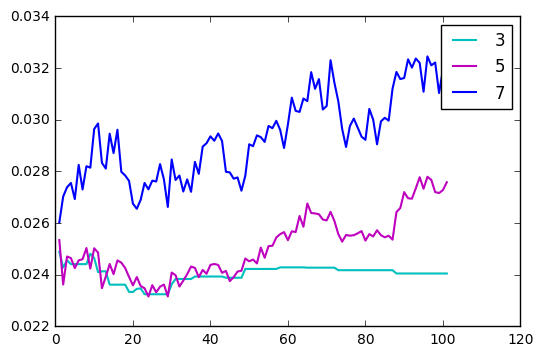


Optimal n_feature = 24, optimal MSE = 0.023159


In [109]:
model_tree = DecisionTreeRegressor(max_depth=5)
model_tree.fit(X_train, y_train)
mse_tree = mean_squared_error(y_test, model_tree.predict(X_test))
print('MSE of Decision Tree:', mse_tree)

Fval, pval = f_regression(X_train, y_train)
ranked_features = [pname for pname, _ in sorted(zip(predictors, Fval), 
                                                key=lambda x: x[1], reverse=True)]

opt_n_feature, opt_mse = 0, 1.0
plt.figure()
for mdepth, color in ((3, 'c'), (5, 'm'), (7, 'b')):
    estimator = DecisionTreeRegressor(max_depth=mdepth)
    scores = []
    for n_f in range(1, n_col+1):
        columns = ranked_features[:n_f]
        sc = - cross_val_score(estimator, X_train.loc[:, columns], y_train, scoring=NMSE, cv=5).mean()
        scores.append(sc)
        if sc < opt_mse:
            opt_n_feature, opt_mse = n_f, sc
    plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=str(mdepth))
plt.legend(loc='upper right')
plt.show()
print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_mse))

# estimator = DecisionTreeRegressor(max_depth=5)
# selector = RFE(estimator, step=1)
# selector = selector.fit(X_train, y_train)
# columns = predictors[selector.support_]
# 
# model_tree.fit(X_train.loc[:, columns], y_train)
# mse_tree = mean_squared_error(y_test, model_tree.predict(X_test.loc[:, columns]))
# print('MSE of Decision Tree after RFE:', mse_tree)

MSE of Random Forest: 0.025157717766


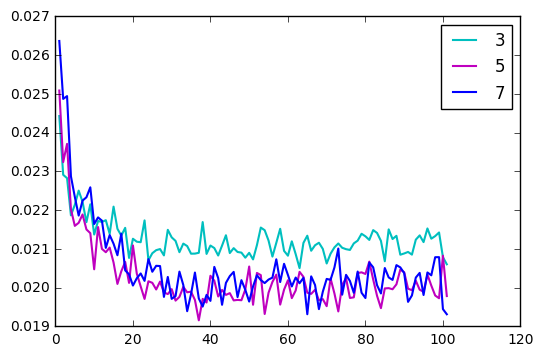


Optimal n_feature = 37, optimal MSE = 0.019158


In [126]:
model_forest = RandomForestRegressor(n_estimators=10, max_depth=3)
model_forest.fit(X_train, y_train)
mse_forest = mean_squared_error(y_test, model_forest.predict(X_test))
print('MSE of Random Forest:', mse_forest)

Fval, pval = f_regression(X_train, y_train)
ranked_features = [pname for pname, _ in sorted(zip(predictors, Fval), 
                                                key=lambda x: x[1], reverse=True)]

opt_n_feature, opt_mse = 0, 1.0
plt.figure()
for mdepth, color in ((3, 'c'), (5, 'm'), (7, 'b')):
    estimator = RandomForestRegressor(n_estimators=10, max_depth=mdepth)
    scores = []
    for n_f in range(1, n_col+1):
        columns = ranked_features[:n_f]
        sc = - cross_val_score(estimator, X_train.loc[:, columns], y_train, scoring=NMSE, cv=3).mean()
        scores.append(sc)
        if sc < opt_mse:
            opt_n_feature, opt_mse = n_f, sc
    plt.plot(range(1, n_col+1), scores, color, linewidth=1.5, label=str(mdepth))
plt.legend(loc='upper right')
plt.show()
print('\nOptimal n_feature = {:d}, optimal MSE = {:f}'.format(opt_n_feature, opt_mse))

In [160]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators': range(3, 11), 'max_depth': range(3, 11)}
clf = GridSearchCV(RandomForestRegressor(), parameters, scoring=NMSE, cv=5)
columns = ranked_features[:37]
clf.fit(X_train.loc[:, columns], y_train)
grid_scores = DataFrame(clf.cv_results_)[['rank_test_score', 'mean_test_score', 'params']]

    rank_test_score  mean_test_score                                params
23                1        -0.019633  {'n_estimators': 10, 'max_depth': 5}


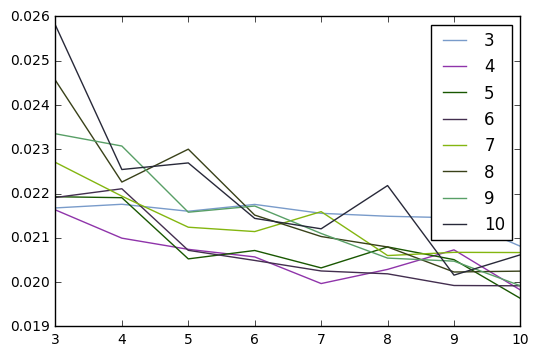

In [161]:
best_sc = best_n_estimator = best_max_depth = 1.0
lines = {i: {j: .0 for j in range(3, 11)} for i in range(3, 11)}
for _, row in grid_scores.iterrows():
    sc, params = row['mean_test_score'], row['params']
    n_estimators, max_depth = params['n_estimators'], params['max_depth']
    lines[max_depth][n_estimators] = - sc
lines = sorted(lines.items(), key=lambda x: x[0])

print(grid_scores[grid_scores['rank_test_score'] == 1])
    
plt.figure()
for max_depth, lst in lines:
    x_val, y_val = list(range(3, 11)), list(lst.values())
    plt.plot(x_val, y_val, color=np.random.rand(3,), label=str(max_depth))
plt.legend(loc='upper right')
plt.show()

In [123]:
col_names = ['rank_test_score', 'mean_test_score', 'params']
print(DataFrame(grid_cv_results).loc[:, col_names])

   rank_test_score  mean_test_score                                 params
0                5        -0.021594    {'n_estimators': 3, 'max_depth': 3}
1                6        -0.021667    {'n_estimators': 5, 'max_depth': 3}
2                3        -0.020903   {'n_estimators': 10, 'max_depth': 3}
3                7        -0.021766    {'n_estimators': 3, 'max_depth': 5}
4                4        -0.021291    {'n_estimators': 5, 'max_depth': 5}
5                1        -0.019669   {'n_estimators': 10, 'max_depth': 5}
6                9        -0.023653   {'n_estimators': 3, 'max_depth': 10}
7                8        -0.021812   {'n_estimators': 5, 'max_depth': 10}
8                2        -0.020311  {'n_estimators': 10, 'max_depth': 10}


In [79]:
model_gb = GradientBoostingRegressor()
model_gb.fit(X_train, y_train)
mse_gb = mean_squared_error(y_test, model_gb.predict(X_test))
print('MSE of Gradient Boosting:', mse_gb)

MSE of Gradient Boosting: 0.0203660442538


In [4]:
# Part-III

# (1) Choosing optimal model & reasoning
features = stepwise_model_select((forward_stepwise, backward_stepwise, bidirectional_stepwise))
print('Finally picked features:\n', Series(features))

'''
From the significant predictors we can find that 
the greater percentage of a complete famliy is usually a boost to greater society environment,
and percentage of various race also have an impact on crime rates.   
'''

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Method forward_stepwise: model-size 37, r2-score 0.6364151740937912


Method backward_stepwise: model-size 37, r2-score 0.6364151740937912


Method bidirectional_stepwise: model-size 35, r2-score 0.6327519563100504

forward_stepwise achieves highest r2 score: 0.6364151740937912
Finally picked features:
 0             PctKids2Par
1                PctIlleg
2              PctFam2Par
3            racePctWhite
4        PctYoungKids2Par
5             PctTeen2Par
6            racepctblack
7              pctWInvInc
8             pctWPubAsst
9            FemalePctDiv
10            TotalPctDiv
11        PctPersOwnOccup
12         MalePctDivorce
13         PctPopUnderPov
14          PctUnemployed
15         PctHousNoPhone
16           PctNotHSGrad
17       PctVacantBoarded
18         PctHousLess3BR
19               NumIlleg
20          PctHousOwnOcc
21       PctPersDenseHous
22            NumUnderPov
23              medFamInc
24              medIncome
25             HousVacant
26        PctLess9thGrade
27        PctLargHouseFam
28          NumInShelters
29             population
30         PctWOFullPlumb
31              numbUrban
32  

'\nFrom the significant predictors we can find that \nthe greater percentage of a complete famliy is usually a boost to greater society environment,\nand percentage of various race also have an impact on crime rates.   \n'

In [5]:
# Part-III

# (2) 10-fold cv
estimator = LinearRegression()
sum_mse = 0.0
for fold in range(1, 11):
    test_rows = X['fold'] == fold
    train_rows = X['fold'] != fold
    X_train, X_test = X.loc[train_rows, features], X.loc[test_rows, features]
    y_true = y[test_rows]
    y_pred = estimator.fit(X_train, y[train_rows]).predict(X_test)
    sum_mse += mean_squared_error(y_true, y_pred)
print('Estimated Test MSE: {:f}'.format(sum_mse / 10.0))

Estimated Test MSE: 0.018972


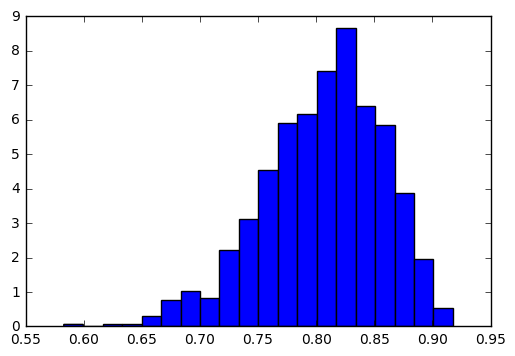

90% Confidential Interval: (0.7168288187074033, 0.8842050174183975)


In [6]:
# (3) Bootstrap sampling & get confidential interval
scores = []
for i in range(1000):
    X_sub, y_sub = resample(X.loc[:, features], y, n_samples=100)
    score = r2_score(y_sub, LinearRegression().fit(X_sub, y_sub).predict(X_sub))
    scores.append(score)
heights, bins, _ = plt.hist(scores, bins=20, normed=True)
plt.show()


def get_conf_interval(heights, bins, ratio):
    threshold = sum(heights) * ratio
    lo = heights.argmax()
    hi = lo + 1
    cur_sum = heights[lo]
    while cur_sum < threshold:
        if lo == 0 or (hi < len(heights) and heights[lo-1] < heights[hi]):
            cur_sum += heights[hi]
            hi += 1
        else:
            cur_sum += heights[lo-1]
            lo -= 1
    return bins[lo], bins[hi]

lo, hi = get_conf_interval(heights, bins, 0.9)
print('90% Confidential Interval: ({}, {})'.format(lo, hi))